In [54]:
import six
import numpy as np
import matplotlib.pyplot as plt
from stompy import utils
import xarray as xr
from matplotlib import colors
%matplotlib notebook

In [266]:
import postprocess_v00 as post
six.moves.reload_module(post)

<module 'postprocess_v00' from '/home/rusty/src/microplastic_sfbay/postprocess/postprocess_v00.py'>

In [203]:
grid_fn="/opt2/sfb_ocean/suntans/runs/merged_018_20171227/ptm_average.nc_0000.nc"  
grid=post.grid_from_ptm_hydro(grid_fn)

In [ ]:
M=grid.smooth_matrix(f=0.5,dx='grid',A='grid',V='grid',K='scaled')

In [228]:
# July-August 2017
ptm_runs=[                                                                                                                                             
        post.PtmRun(run_dir="/opt2/sfb_ocean/ptm/all_source/20170615/w-0.05"),                                                                                  
        post.PtmRun(run_dir="/opt2/sfb_ocean/ptm/all_source/20170615/w-0.005"),                                                                                 
        post.PtmRun(run_dir="/opt2/sfb_ocean/ptm/all_source/20170615/w-0.0005"),                                                                                
        post.PtmRun(run_dir="/opt2/sfb_ocean/ptm/all_source/20170615/w0.0"),                                                                                    
        post.PtmRun(run_dir="/opt2/sfb_ocean/ptm/all_source/20170615/w0.0005"),                                                                                 
        post.PtmRun(run_dir="/opt2/sfb_ocean/ptm/all_source/20170615/w0.005"),                                                                                  
        post.PtmRun(run_dir="/opt2/sfb_ocean/ptm/all_source/20170615/w0.05"),                                                                                   
]                                                                                                                                                      

time_range=[np.datetime64('2017-07-15'),np.datetime64('2017-08-14')]

In [282]:
# A 1 hour window gives 27k particles

group_patt='.*_down500'        
part_obs24=post.query_runs(ptm_runs,
                         group_patt=group_patt,
                         time_range=[np.datetime64("2017-07-22 00:00"),
                                     np.datetime64("2017-07-23 00:00")],
                         z_range=None, # not ready
                         max_age=np.timedelta64(30,'D'),
                         conc_func=post.conc_func,
                         grid=grid)


INFO:root:/opt2/sfb_ocean/ptm/all_source/20170615/w-0.0005: src001_down500
INFO:root:/opt2/sfb_ocean/ptm/all_source/20170615/w-0.0005: palo_alto_down500
INFO:root:/opt2/sfb_ocean/ptm/all_source/20170615/w-0.0005: src000_down500
INFO:root:/opt2/sfb_ocean/ptm/all_source/20170615/w-0.0005: san_jose_down500
INFO:root:/opt2/sfb_ocean/ptm/all_source/20170615/w-0.0005: fs_down500
INFO:root:/opt2/sfb_ocean/ptm/all_source/20170615/w-0.0005: SJRiver_down500
INFO:root:Got SJRiver -- returning 0.0
INFO:root:Will skip source SJRiver, behavior down500, its concentration is 0
INFO:root:/opt2/sfb_ocean/ptm/all_source/20170615/w-0.0005: UALAMEDA_down500
INFO:root:/opt2/sfb_ocean/ptm/all_source/20170615/w-0.0005: SCLARAVCc_down500
INFO:root:/opt2/sfb_ocean/ptm/all_source/20170615/w-0.0005: petaluma_down500
INFO:root:Will skip source petaluma -- it's in skip_source
INFO:root:/opt2/sfb_ocean/ptm/all_source/20170615/w-0.0005: NAPA_down500
INFO:root:/opt2/sfb_ocean/ptm/all_source/20170615/w-0.0005: SacRiver

In [289]:
six.moves.reload_module(post)
part_obs24=post.add_z_info(part_obs24,grid,ptm_runs)

In [291]:
# set up ptm_runs with a small set of local runs.
# make sure that we're reading the correct grid, presumably
# by reading the ptm_average file from the first ptm_run
# and using the one-off code in postprocess_v00.py to
# load as a grid.
# check to see that when the right grid is in use, part_hab
# is well behaved.

part24_bed=post.filter_by_z_range(part_obs24,[0.0,0.5],grid,ptm_runs)
part24_surf=post.filter_by_z_range(part_obs24,[-0.5,0.0],grid,ptm_runs)

In [298]:
part24_bed.dims['particle']

264139

In [299]:
part24_surf.dims['particle']

101635

In [293]:
conc0_bed=post.particle_to_density(part24_bed,grid)
conc0_surf=post.particle_to_density(part24_surf,grid)

In [294]:
def smooth(c): 
    for _ in range(20):
        c=M.dot(c)
    return c

conc_bed=smooth(conc0_bed)
conc_surf=smooth(conc0_surf) 

In [305]:
part_obs24.variables['ptm_groups'].dims

('ptm_groups',)

In [295]:
class BayConcFigure(object):
    figsize=(9,7)
    vmin=1e-6
    vmax=1e-2
    zoom=(517521., 613202., 4139744., 4230105.)
    cax_loc=[0.7,0.25,0.03,0.35]
    num=None
    def __init__(self,conc,**kw):
        utils.set_keywords(self,kw)
                    
        self.fig=plt.figure(figsize=(10,8),num=self.num)
        self.ax=self.fig.add_subplot(1,1,1)
        
        self.ccoll=grid.plot_cells(values=conc.clip(self.vmin,self.vmax),
                                   cmap='jet',norm=colors.LogNorm(vmin=self.vmin,vmax=self.vmax),
                                   edgecolor='face',lw=0.4,ax=self.ax)
        self.cax=self.fig.add_axes(self.cax_loc)
        plt.colorbar(ccoll,cax=self.cax)
        self.ax.set_aspect('equal')
        self.ax.xaxis.set_visible(0)
        self.ax.yaxis.set_visible(0)
        self.ax.axis(self.zoom)
        self.fig.subplots_adjust(left=0.01,right=0.99,top=0.99,bottom=0.01)
        

<IPython.core.display.Javascript object>


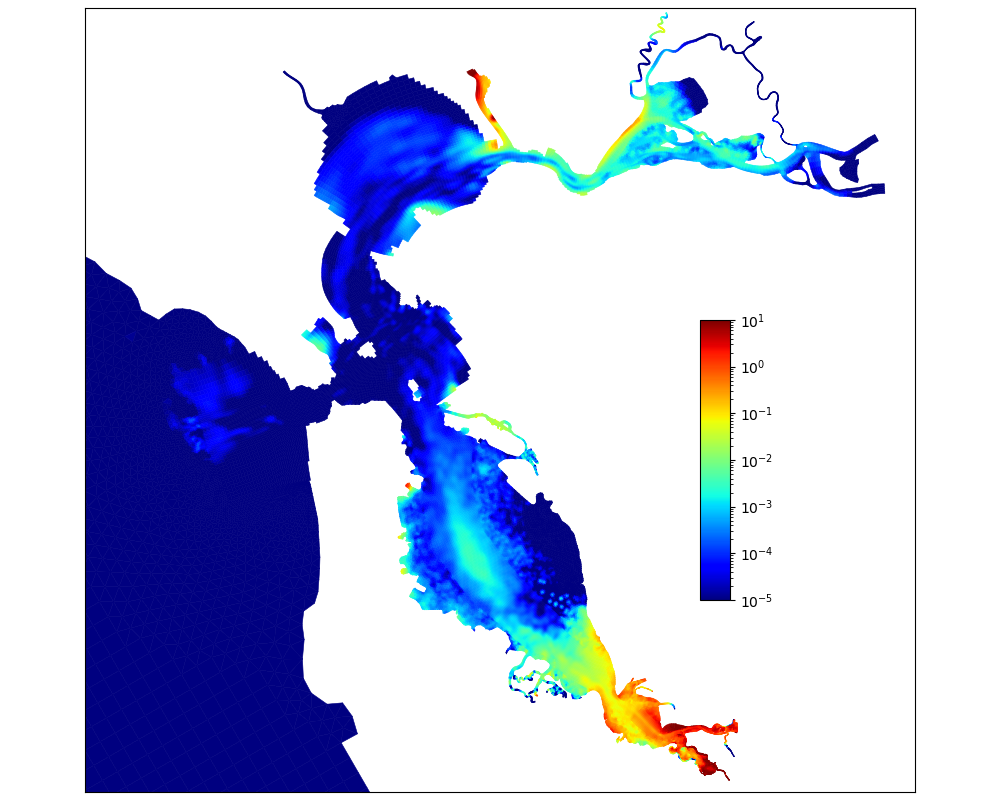

In [296]:
bfig=BayConcFigure(conc_bed)

<IPython.core.display.Javascript object>


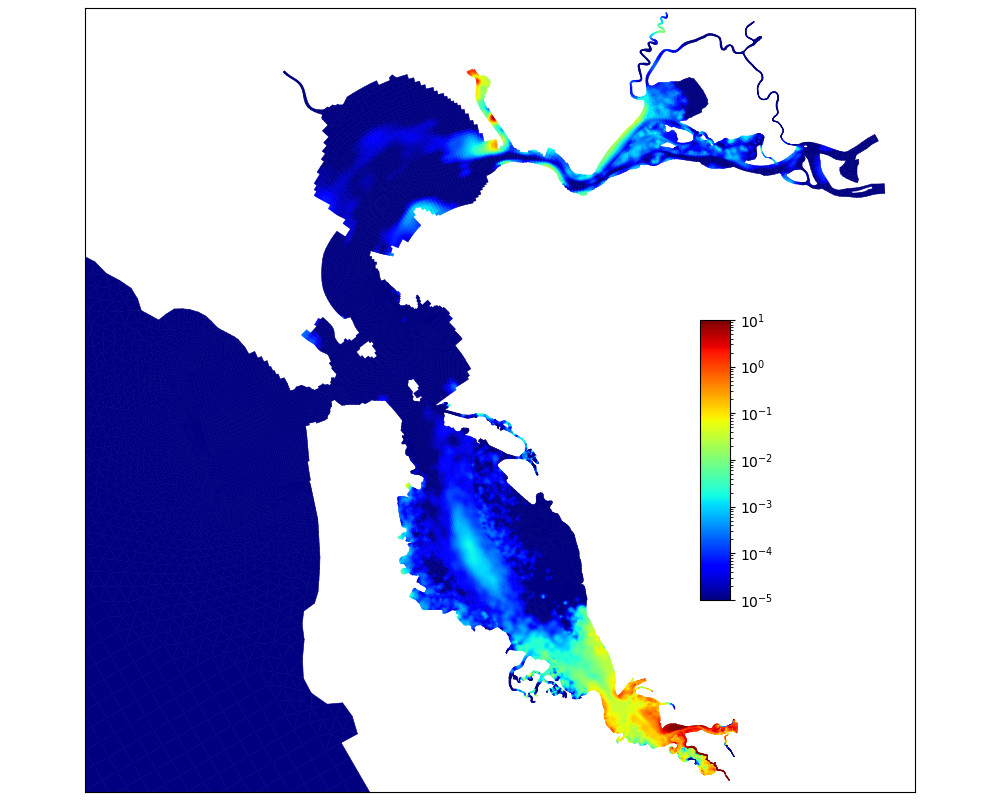

In [297]:
bfig=BayConcFigure(conc_surf)

<IPython.core.display.Javascript object>


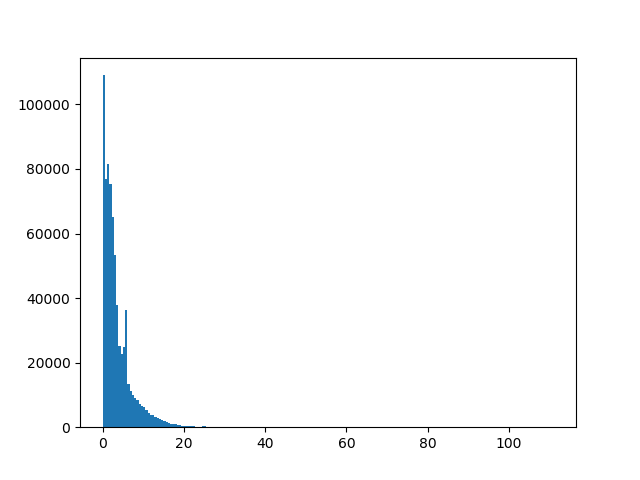

/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


In [280]:
hbs=part_obs24['z_surf'].values-part_obs24.x.values[:,2]

plt.figure()
plt.hist(hbs,200);